# Order Retraction

Computes and plot order retraction. Needs the executable `CMGDB_RETRACT`.

In [1]:
import CMGDB

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import graphviz
import numpy as np
import time
import math
import csv

In [2]:
def PlotOrderRetraction(morse_graph, map_graph, retract_tiles, retract_indices,
                        morse_nodes_map=None, morse_nodes=None, proj_dims=None,
                        fig_w=8, fig_h=8, xlim=None, ylim=None, cmap=matplotlib.cm.brg):
    num_morse_sets = morse_graph.num_vertices()
    num_verts = map_graph.num_vertices()
    if morse_nodes_map == None:
        morse_nodes_map = {}
    if morse_nodes == None:
        morse_nodes = range(num_morse_sets)
    if proj_dims == None:
        d1 = 0
        d2 = 1
    else:
        d1 = proj_dims[0]
        d2 = proj_dims[1]
    rect = morse_graph.phase_space_box(0)
    dim = int(len(rect) / 2)
    rect_width = rect[dim + d1] - rect[d1]
    rect_height = rect[dim + d2] - rect[d2]
    # Get min and max x and y values
    grid_boxes = [morse_graph.phase_space_box(i) for i in range(num_verts)]
    if xlim == None:
        x_min = min([rect[d1] for rect in grid_boxes])
        x_max = max([rect[dim + d1] for rect in grid_boxes])
        if x_max - x_min < 0.1:
            x_min -= 0.05
            x_max += 0.05
    else:
        x_min = xlim[0]
        x_max = xlim[1]
    if ylim == None:
        y_min = min([rect[d2] for rect in grid_boxes])
        y_max = max([rect[dim + d2] for rect in grid_boxes])
        if y_max - y_min < 0.1:
            y_min -= 0.05
            y_max += 0.05
    else:
        y_min = ylim[0]
        y_max = ylim[1]
    x_axis_width = x_max - x_min
    y_axis_height = y_max - y_min
    # Next plot order retraction and Morse sets
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    # Set axis limits
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    # Normalization for color map
    cmap_norm = matplotlib.colors.Normalize(vmin=0, vmax=num_morse_sets-1)
    # Plot order retract boxes
    for m_node in morse_nodes:
        # m_node is the index in the original Morse graph
        clr = matplotlib.colors.to_hex(cmap(cmap_norm(m_node)))
        # Get the index of the Morse set in the order retraction Morse graph
        morse_node = morse_nodes_map[m_node] if m_node in morse_nodes_map else m_node
        tiles_inds = [i for i in range(num_verts) if retract_tiles[i] == morse_node]
        morse_retract = [morse_graph.phase_space_box(retract_indices[i]) for i in tiles_inds]
        rectangles_list = []
        for rect in morse_retract:
            rectangle = Rectangle((rect[d1], rect[d2]), rect_width, rect_height)
            rectangles_list.append(rectangle)
        pc = PatchCollection(rectangles_list, cmap=cmap, fc=clr, alpha=0.3, ec='none')
        ax.add_collection(pc)
    # Plot Morse set boxes
    for morse_node in morse_nodes:
        clr = matplotlib.colors.to_hex(cmap(cmap_norm(morse_node)))
        rectangles_list = []
        for index in morse_graph.morse_set(morse_node):
            rect = morse_graph.phase_space_box(index)
            rectangle = Rectangle((rect[d1], rect[d2]), rect_width, rect_height)
            rectangles_list.append(rectangle)
        pc2 = PatchCollection(rectangles_list, cmap=cmap, fc=clr, alpha=1.0, ec='none')
        ax.add_collection(pc2)
    plt.show()

In [3]:
# Leslie map with padding

# Define Leslie map
def f(x):
    th1 = 19.6
    th2 = 23.68
    return [(th1 * x[0] + th2 * x[1]) * math.exp (-0.1 * (x[0] + x[1])), 0.7 * x[0]]

# Define box map for f
def F(rect):
    return CMGDB.BoxMap(f, rect, padding=False)

In [4]:
phase_subdiv = 18
lower_bounds = [-0.001, -0.001]
upper_bounds = [90.0, 70.0]

model = CMGDB.Model(phase_subdiv, lower_bounds, upper_bounds, F)

In [5]:
%%time
morse_graph, map_graph = CMGDB.ComputeMorseGraph(model)

CPU times: user 10.5 s, sys: 66.8 ms, total: 10.5 s
Wall time: 10.7 s


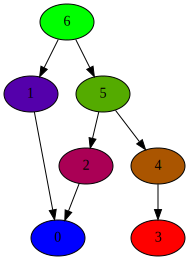

In [6]:
CMGDB.PlotMorseGraph(morse_graph)

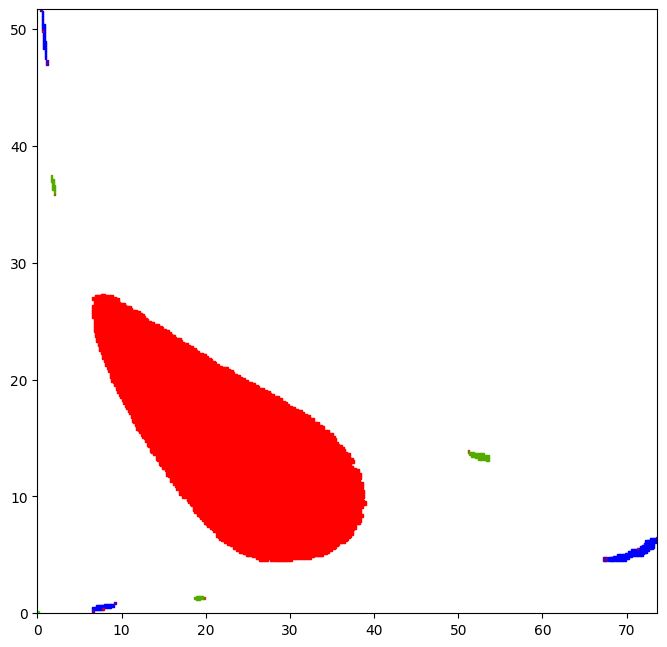

In [7]:
CMGDB.PlotMorseSets(morse_graph, fig_w=8, fig_h=8)

# Compute Order Retraction

Save MVMap to file for CMGDB_Retract

In [8]:
%%time
with open('CMGDB_mvmap.txt','w') as outfile:
    outfile.write('%d\n' % map_graph.num_vertices())
    for k in range(map_graph.num_vertices()):
        l = len(map_graph.adjacencies(k))
        outfile.write('%d ' % k)
        outfile.write('%d ' % l)
        for v in map_graph.adjacencies(k):
            outfile.write('%d ' % v)
        outfile.write('\n')

CPU times: user 12.7 s, sys: 134 ms, total: 12.9 s
Wall time: 13.5 s


Compute order retraction

In [9]:
%%time
!./CMGDB_RETRACT
!rm RETRACT_LOG.txt

Loading boxes and images from CMGDB.... Sun May 23 04:58:51 2021

Loading 262144 boxes...
Loading mvmap on 262144 boxes...
Number of BOXES = 262144
--------------------------------

Computing recurrence ...Sun May 23 04:58:53 2021

Number of recurrent components = 7 :: 13 + 73 + 4 + 15407 + 3 + 225 + 1 = 15726

--------------------------------

Creating poset....Sun May 23 04:58:54 2021

Computing P-relations....Sun May 23 04:58:56 2021

Writing Hasse.dot ...Sun May 23 04:58:57 2021

RC size 7 : 7
H 0 -> 5 
H 1 -> 2 4 
H 2 -> 3 
H 3 -> 
H 4 -> 5 
H 5 -> 
H 6 -> 0 1 
Computing initial candidates....Sun May 23 04:58:57 2021

RC : succ : pred : parallel : empty == 7 : 243396 : 2 : 3020 : 0

Trimming candidates....Sun May 23 04:58:58 2021

empty candidiates list after trimming 0

Order retraction exists? : 1
Computing retraction....Sun May 23 04:58:58 2021

Writing tiles....Sun May 23 04:58:59 2021

noretract_count: 0

FINISHED! Sun May 23 04:59:01 2021


CPU times: user 162 ms, sys: 60.1 

Load retraction from file

In [10]:
with open('CMGDB_retract.txt','r') as infile:
    retract_indices = []
    retract_tiles = []
    for i in range(map_graph.num_vertices()): 
        index, tile = [int(x) for x in next(infile).split()]
        retract_indices.append(index)
        retract_tiles.append(tile)

Display Hasse diagram using Graphviz to compare to Morse graph. The index labels of the Morse sets may have changed.

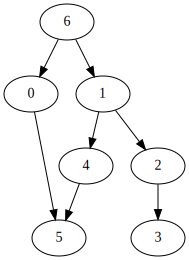

In [11]:
graphviz.Source.from_file('Hasse.dot')

Now we need to look at the original Morse graph and the new Morse graph above and create a mapping (a dictionary) from the indices of the original Morse graph to the indices of this new Morse graph. Only the indices that changed need to be included in the mapping. In the example above the mapping is given below.

In [12]:
# The original indices 1, 5, 4, 2, and 0 became 0, 1, 2, 4, and 5, respectively.
# So we set the following dictionary:
morse_nodes_map = {1: 0, 5: 1, 4: 2, 2: 4, 0: 5}

Using all the data above we can now call the function to plot the order retraction. The color are automatically set from the mappign above.

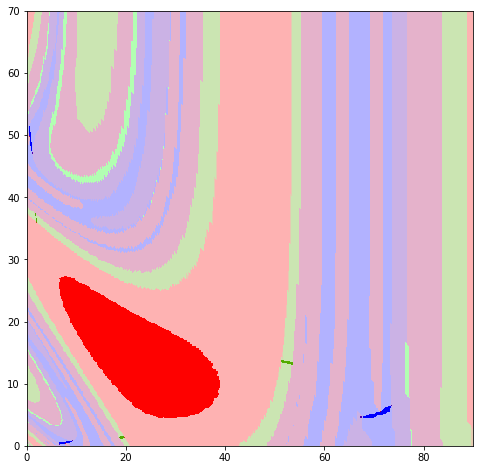

In [13]:
PlotOrderRetraction(morse_graph, map_graph, retract_tiles, retract_indices, morse_nodes_map)

We can also select a different color map as below.

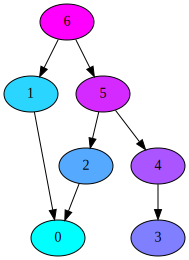

In [14]:
CMGDB.PlotMorseGraph(morse_graph, cmap=matplotlib.cm.cool)

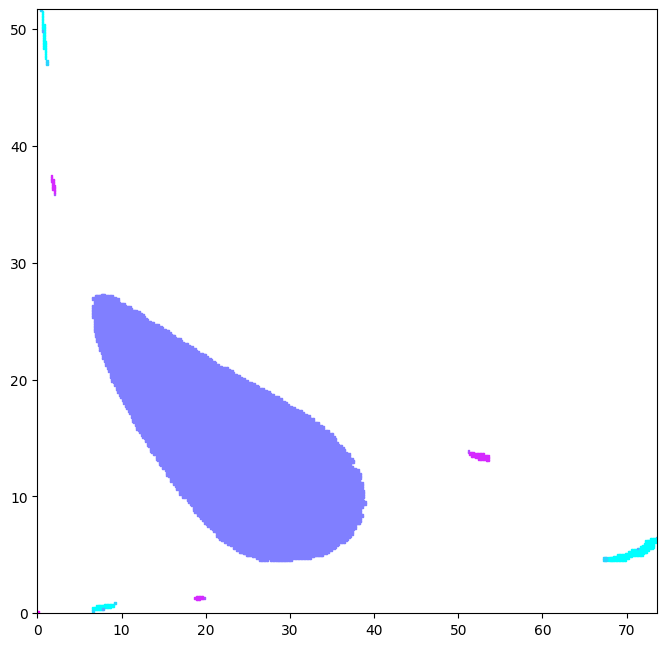

In [15]:
CMGDB.PlotMorseSets(morse_graph, fig_w=8, fig_h=8, cmap=matplotlib.cm.cool)

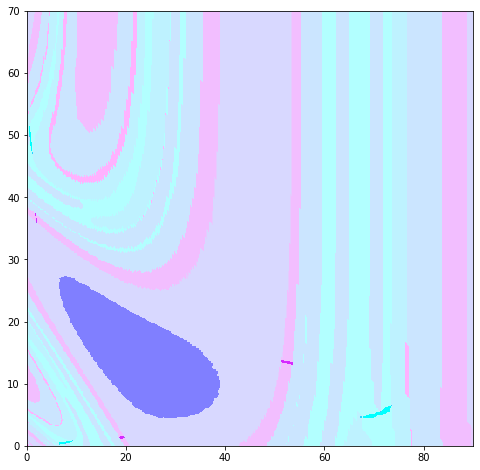

In [16]:
PlotOrderRetraction(morse_graph, map_graph, retract_tiles,
                    retract_indices, morse_nodes_map, cmap=matplotlib.cm.cool)

We can also plot only slected Morse sets and their order retraction by passing a list of Morse nodes. The indices of the Morse sets refer to the indices in the original Morse graph.

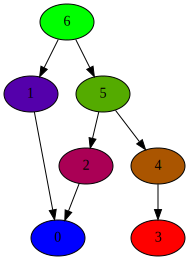

In [17]:
CMGDB.PlotMorseGraph(morse_graph)

Let's plot only the attractors (nodes 0 and 3) and their order retraction.

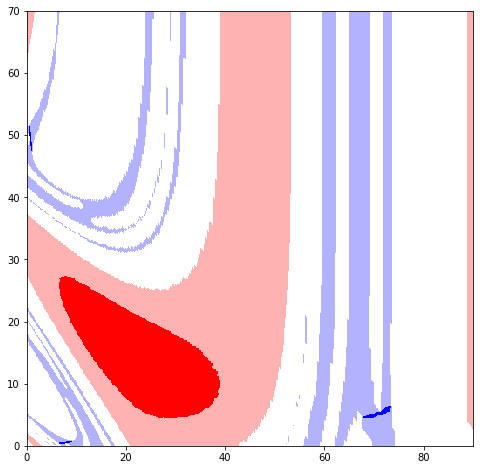

In [18]:
PlotOrderRetraction(morse_graph, map_graph, retract_tiles, retract_indices,
                    morse_nodes_map, morse_nodes=[0, 3])